# A Basic Example, Evaluated Four Ways

Bennet Meyers
3/17/21

We construct a signal decomposition problem by summing Gaussian noise, a smooth signal (small second-order differences), and a piecewise constant signal. We then look to solve the associated Signal Decomposition (SD) optimization problem. 

We look at two class definitions for the piecewise constant signal. The first class is the set of all piecewise constant functions with a known number of jumps. This is a non-convex class and is formally defined as a cardinality constraint on the first-order difference of the signal. The second definition is defined by the L1 penalty on the first-order difference, that is, the convex relaxation of the first class.

We also look at solving the problem two ways, first with ADMM and second with CVXPY. As we see below, we of course cannot solve the non-convex forumulation with CVXPY.

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, PiecewiseConstant, SparseFirstDiffConvex
from osd.generators import proj_l2_d2, make_pwc_data
from osd.utilities import progress

## Problem data generation

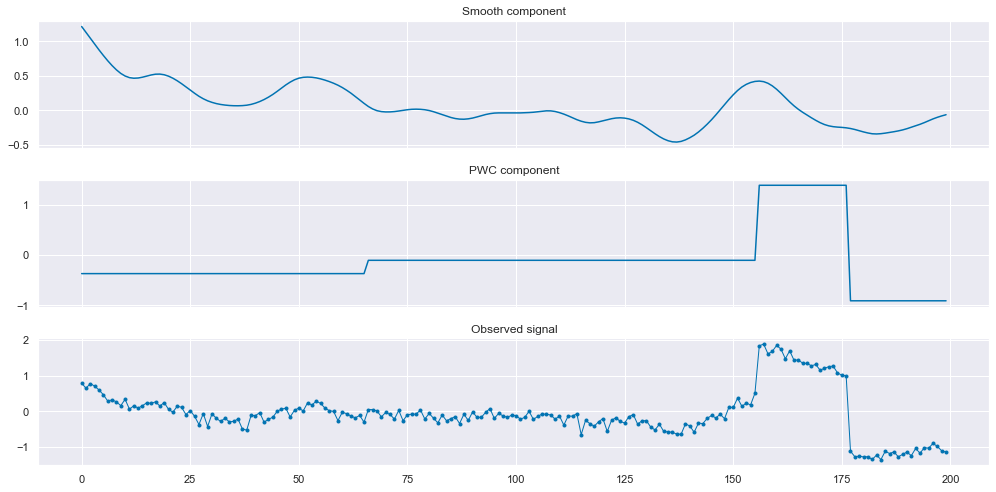

In [4]:
T = 200
X_real = np.zeros((3, T))
X_real[0] = 0.1 * np.random.randn(T)
X_real[1] = proj_l2_d2(np.random.randn(T), theta=5e2) * 2
X_real[2] = make_pwc_data(T, segments=4)
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(X_real[1])
ax[1].set_title('PWC component')
ax[1].plot(X_real[2])
ax[2].set_title('Observed signal')
ax[2].plot(y, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()

## Cardinality-constrained formulation

### Solve with ADMM

In [5]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=1e2)
c3 = PiecewiseConstant(num_segments=4)
components = [c1, c2, c3]
problem = Problem(y, components)

In [6]:
problem.decompose(admm=True, rho=1, num_iter=100)

[============================================================] 100.0% ...27.26 sec


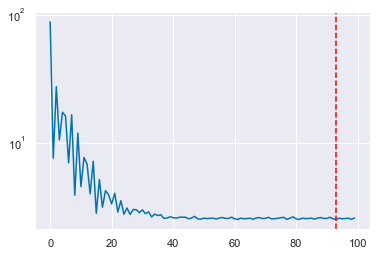

In [7]:
plt.plot(problem.admm_result['obj_vals'])
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')

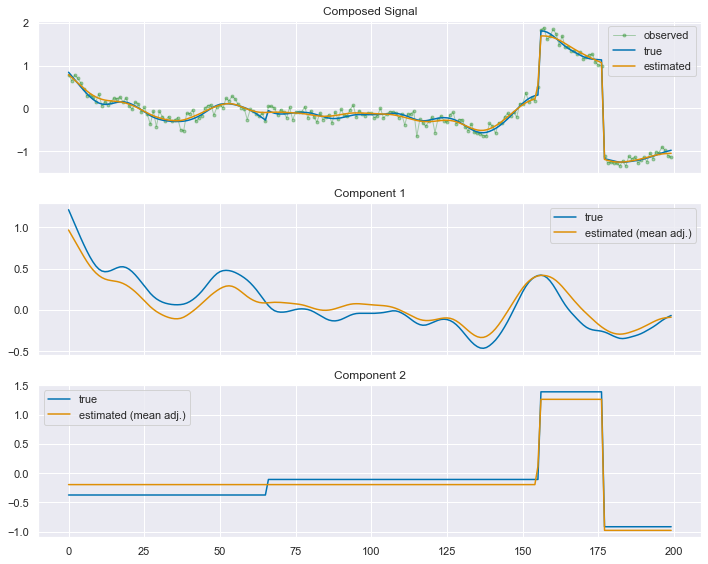

In [8]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true')
        ax[k].plot(est - np.average(est) + np.average(true), label='estimated (mean adj.)')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()

### Solve with CVXPY

In [9]:
problem.decompose(admm=False)

This problem is non-convex and not solvable with CVXPY. Please try solving with ADMM.


In [10]:
print([c.is_convex for c in problem.components])

[True, True, False]


## $\ell_1$-penalized formulation

### Solve with ADMM

In [11]:
c1 = GaussNoise()
c2 = SmoothSecondDifference(theta=1e2)
c3 = SparseFirstDiffConvex(theta=1e0)
components = [c1, c2, c3]
problem = Problem(y, components)

In [12]:
problem.decompose(admm=True, rho=1, num_iter=100)

[============================================================] 100.0% ...4.28 sec


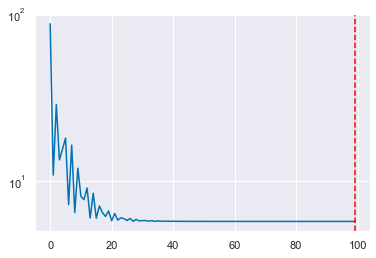

In [13]:
plt.plot(problem.admm_result['obj_vals'])
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')

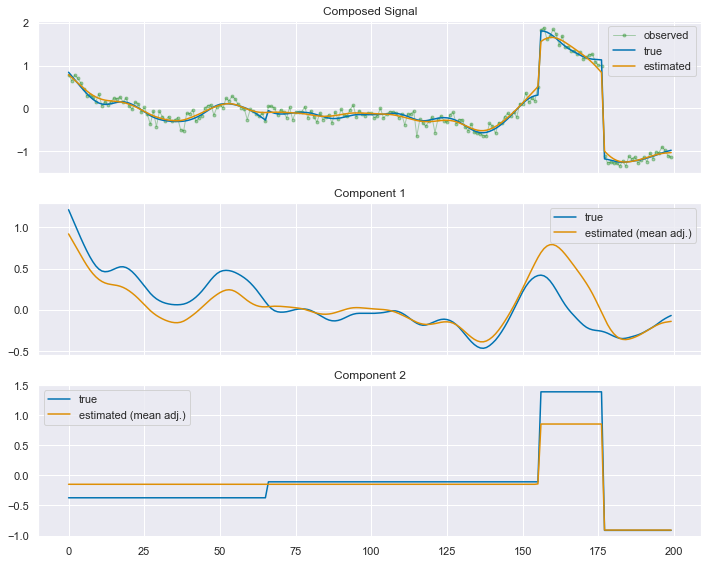

In [14]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true')
        ax[k].plot(est - np.average(est) + np.average(true), label='estimated (mean adj.)')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()

### Solve with CVXPY

In [15]:
problem.weights.value = [c.theta for c in problem.components]
problem.decompose(admm=False, solver='MOSEK')

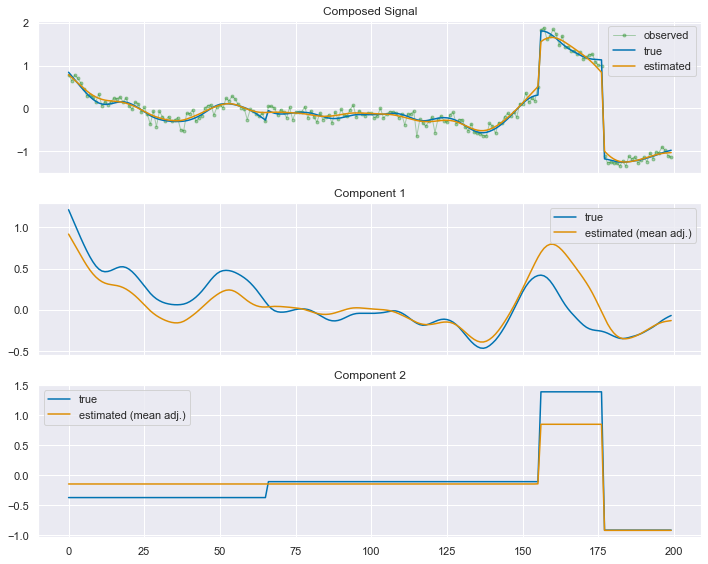

In [16]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(10,8))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true')
        ax[k].plot(est - np.average(est) + np.average(true), label='estimated (mean adj.)')
        ax[k].set_title('Component {}'.format(k))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=1, alpha=0.3, marker='.', color='green')
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true')
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated')
        ax[k].set_title('Composed Signal')
    ax[k].legend()
plt.tight_layout()